In [73]:
#this is an iteration of https://github.com/akcarsten/fMRI_data_analysis/blob/master/Intro_to_fMRI_Data_Part_I_Data_Structure.ipynb

import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt

%matplotlib inline

In [74]:
#after downloading the dataset, we find all files in the structural data folder
data_path = 'Desktop/fmri/sM00223/'
files = os.listdir(data_path)

#and read the data
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_fdata()

In [75]:
#to know the number of elements in each dimension
print(data.shape)

(256, 256, 54, 1)


In [76]:
#rotating in such a way that the figures face upwards + dropping the 4th dimension
data = np.rot90(data.squeeze(), 1)
print(data.shape)

(256, 256, 54)


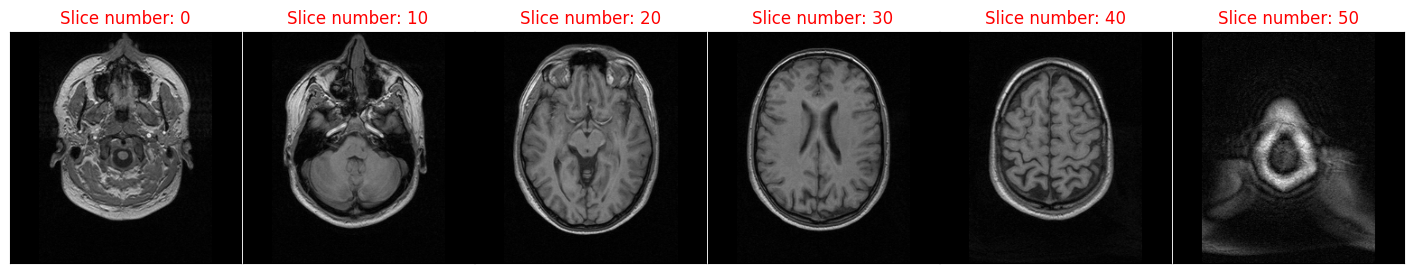

In [77]:
#taking a look at every 10th slice of the scan since 54 slices are too much to display
fig, ax = plt.subplots(1, 6, figsize=[18,3])

n = 0
slice = 0
for _ in range(6):
    ax[n].imshow(data[:, :, slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 10

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [78]:
#now looking at the functional data
#basic information about the data acquisition
x_size = 64
y_size = 64
n_slice = 64
n_volumes = 96 #acquisitions/data points

#find all files in the data folder
data_path = 'Desktop/fmri/fM00223/'
files = os.listdir(data_path)

#read the data and organize w.r.t. the acquisition parameters
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr' :
        data = nibabel.load(data_path + data_file).get_fdata()
        data_all.append(data.reshape(x_size, y_size, n_slice))

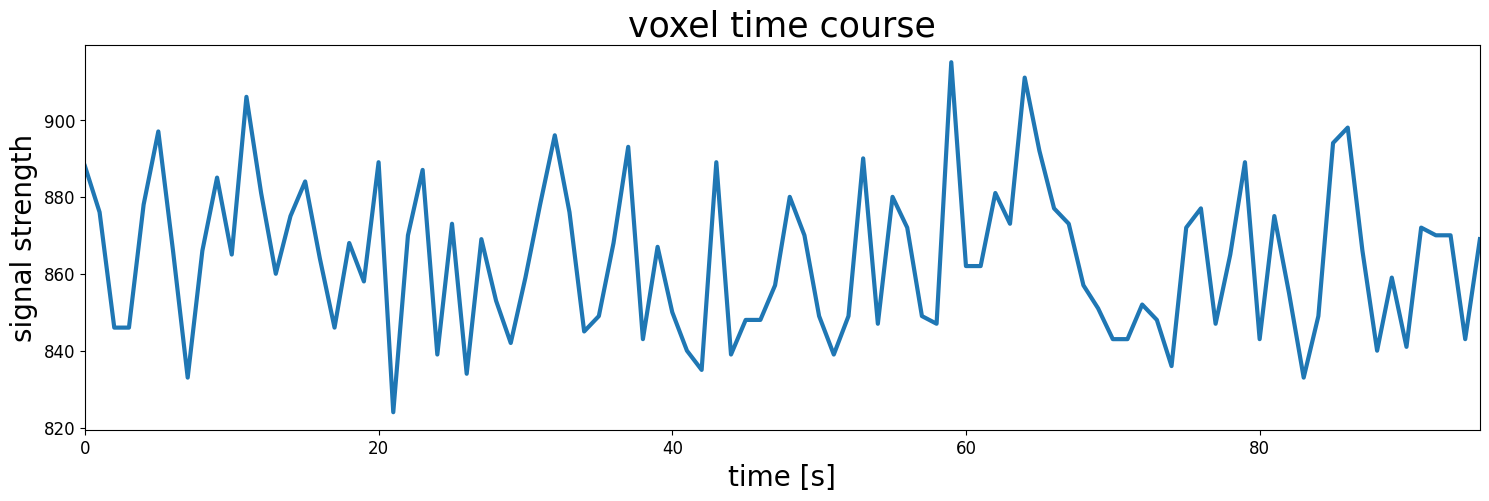

In [79]:
#organize the data in the transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 0])
transversal = np.rot90(transversal, 2)

#create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

#plot the timecourse of a random voxel
ax.plot(transversal[30, 30, 35, :], lw=3)
ax.set_xlim([0, transversal.shape[3]-1])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

plt.show()

In [80]:
#rearranging and reshaping data for export for the purpose of not reorganizing the data again in the future
#this creates .csv file for each slice with spatial and temporal dimensions
#we reshape each slice into a MxN (M = y_size*x_size and N = n_volumes) matrix to be accommodated in the .csv file
data_all = np.transpose(data_all, [3, 2, 1, 0])
data_all = np.reshape(data_all, [n_slice, y_size*x_size, n_volumes])

#checking if the output path already exists; creating if not
if os.path.exists('Desktop/fmri/csv_data') == False :
    os.mkdir('Desktop/fmri/csv_data')

#exporting each slice as a csv file
n = 0
for export in data_all:

    save_file = 'slice_{}.csv'.format(n)
    save_path = 'Desktop/fmri/csv_data/{}'.format(save_file)
    pd.DataFrame(export).to_csv(save_path, header=False, index=False)
    n += 1

In [81]:
#part 2

#import the data of 1 slice
data = np.genfromtxt('Desktop/fmri/csv_data/slice_36.csv', delimiter=',')

In [82]:
# These are the main parameters of the fMRI scan and experimental desgin
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT #42 seconds

acq_num         = block_size*block_total #96 accquisitions
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

In [83]:
print(data.shape)

(4096, 96)


In [84]:
#reshape the data to 2 spatial and 1 temporal dimensions
data_ordered = data.reshape(x_size,y_size,acq_num)
print(data_ordered.shape)

(64, 64, 96)


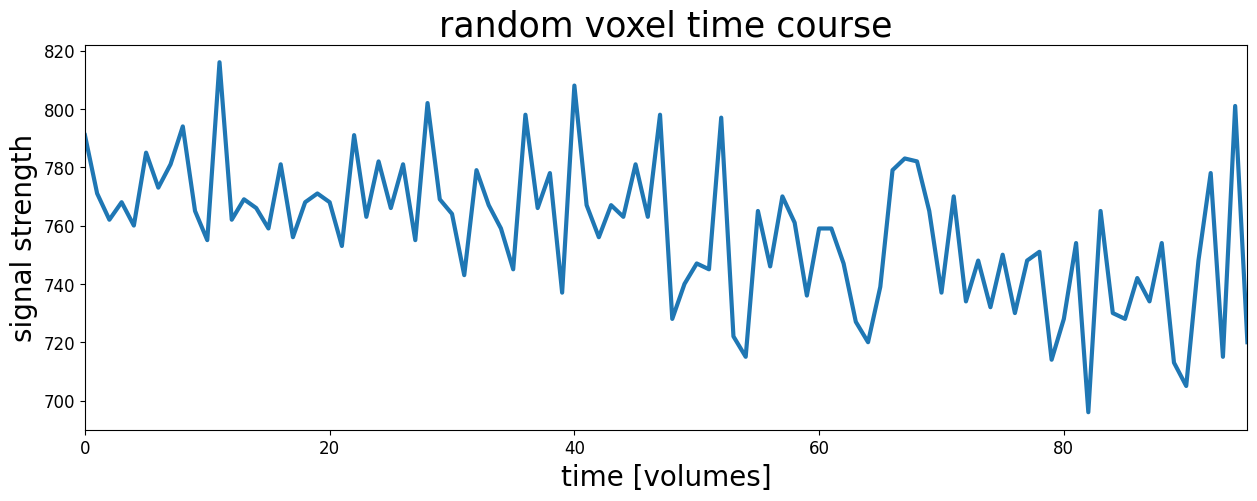

In [85]:
#select a random voxel by getting one random x- and y-coorinate
x_voxel = np.random.randint(64)
y_voxel = np.random.randint(64)

#create the plot
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(data_ordered[x_voxel, y_voxel], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('random voxel time course', fontsize=25)
ax.tick_params(labelsize=12)
plt.show()

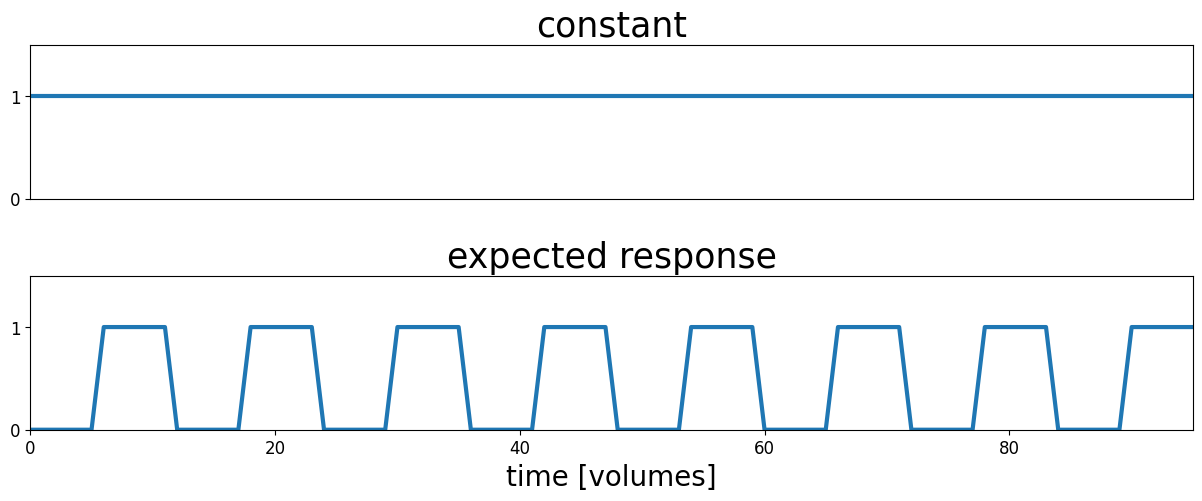

In [86]:
#the time-series plot above is a bit chaotic and hard to understand
#looks like there's no significant stim and rest behavior/response that can be inferred

#so, we create the design matrix of the expected response (to get a good approximation)
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

#create the plots
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [volumes]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

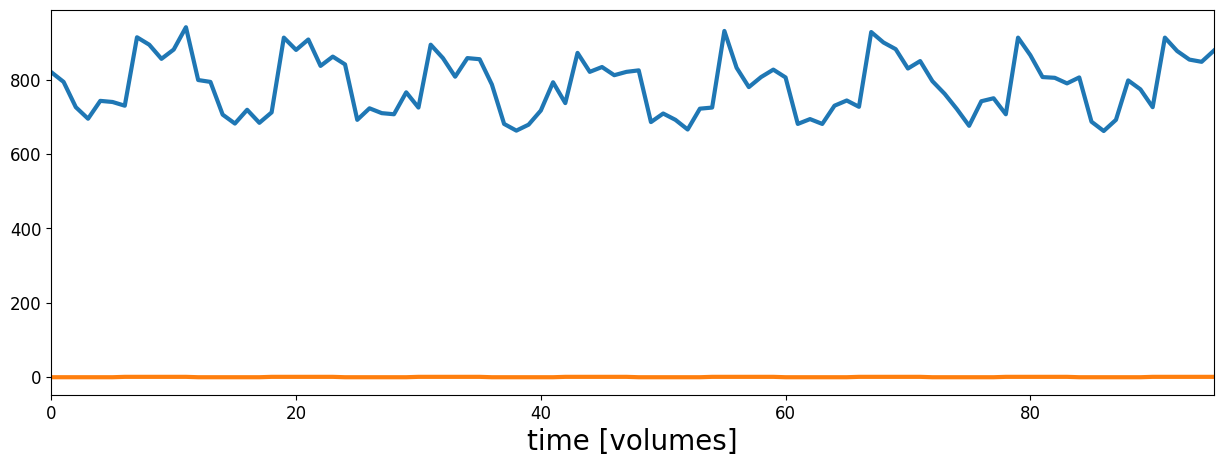

In [87]:
#next, calculate the correlation coefficients
c = np.corrcoef(design_matrix[1,:], data)[1:,0]

#find the voxel with the highest correlation coefficient
strongest_correlated = data[c.argmax(),:]

#create the plots
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(strongest_correlated, lw=3)
ax.plot(design_matrix[1,:], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
plt.show()

In [88]:
#define the min-max scaling function
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

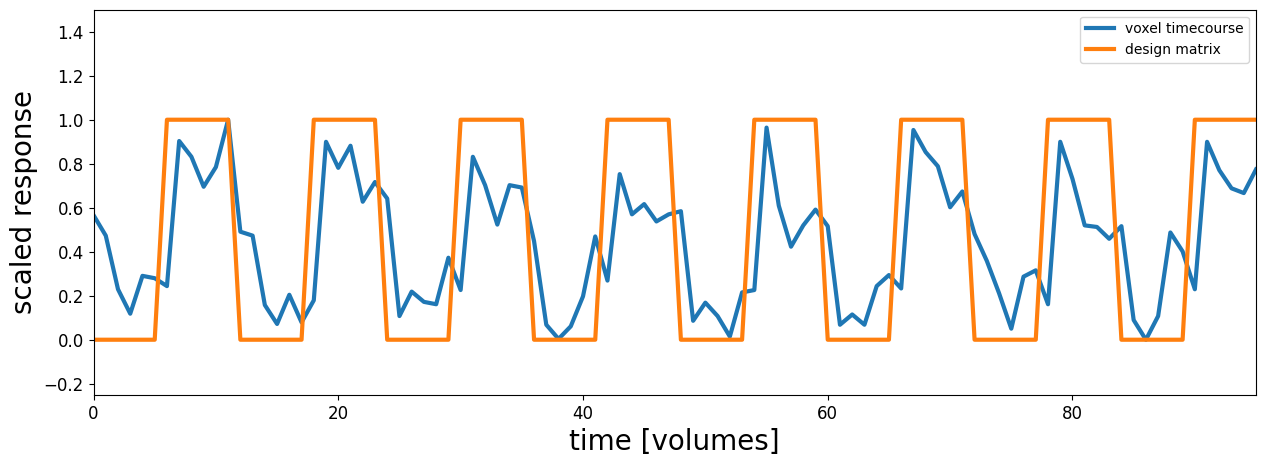

In [89]:
#scale the voxel with the highest correlation
strongest_correlated_scaled = scale(data[c.argmax(),:])

#create the plots
fig, (ax) = plt.subplots(1,1,figsize=(15, 5))
ax.plot(strongest_correlated_scaled, label='voxel timecourse', lw=3)
ax.plot(design_matrix[1,:], label='design matrix', lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(-0.25, 1.5)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('scaled response', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()
plt.show()

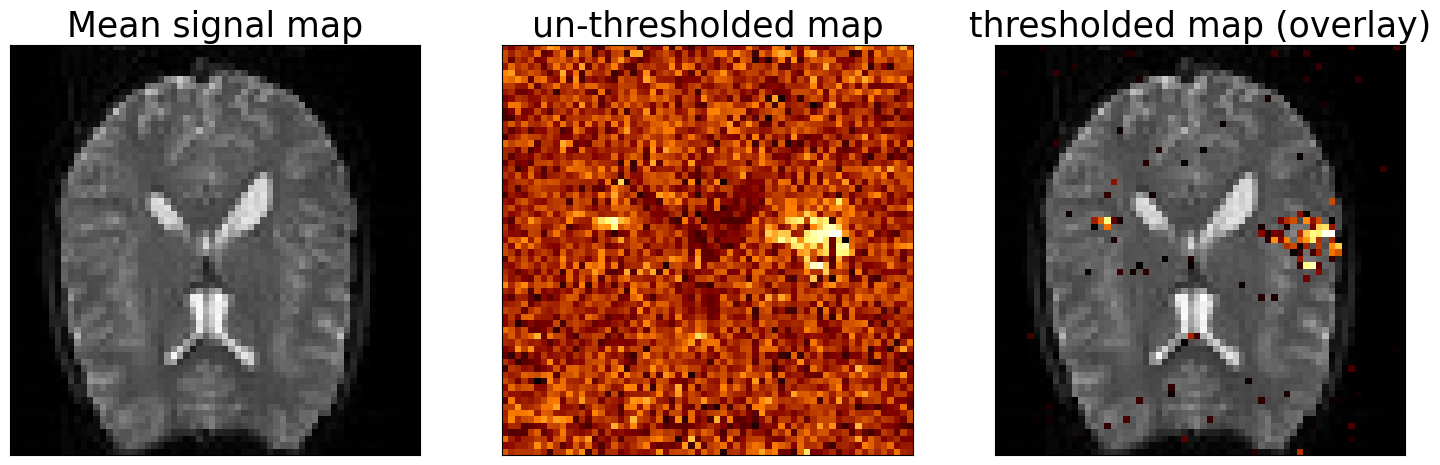

In [91]:
#mapping the voxels with high correlation onto the brain image

mean_data = data_ordered.mean(axis=2)

corr = c.reshape(x_size, y_size)
map = corr.copy()
map[map < 0.2] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('Mean signal map', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(corr,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()